In [1]:
import itertools
import os

import matplotlib.pylab as plt
import numpy as np

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds

!pip install tensorflow_hub
!pip install vit_keras
!pip install -U tensorflow-addons
from vit_keras import vit

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
import functools

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [2]:
(raw_train, raw_validation, raw_test), metadata = tfds.load(
    name="oxford_flowers102",
    split=['test', 'validation', 'train'],
    with_info=True,
    as_supervised=True,
    batch_size=32
)

In [3]:
img_size = 224
batch_size = 16
epochs = 40
learning_rate = 0.001
weight_decay = 0.0001
learning_rate = 1e-3

In [4]:
def normalize_img(image, label):
  image = tf.cast(image, tf.float32)
  image = (image/127.5) - 1
  image = tf.image.resize(image, (img_size, img_size))
  return  image, label

In [5]:
train = raw_train.map(normalize_img)
validation = raw_validation.map(normalize_img)
test = raw_test.map(normalize_img)

del raw_train
del raw_validation
del raw_test

In [6]:
train = train.unbatch().batch(batch_size,drop_remainder=True).repeat().shuffle(512)
validation_data = validation.unbatch().batch(batch_size,drop_remainder=True).repeat()

In [7]:
steps_per_epoch = metadata.splits["train"].num_examples / batch_size 
validation_steps = metadata.splits["validation"].num_examples / batch_size

In [8]:
base = vit.vit_b16(
        image_size = img_size,
        activation = 'gelu',
        pretrained = True,
        include_top = False,
        pretrained_top = False,
        classes = 102)

347502902/347502902 [==============================] - 3s 0us/step


/usr/local/lib/python3.10/dist-packages/vit_keras/utils.py:81: UserWarning: Resizing position embeddings from 24, 24 to 14, 14
  warnings.warn(


In [9]:
model = tf.keras.Sequential([
    base,
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(102)
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vit-b16 (Functional)        (None, 768)               85798656  
                                                                 
 batch_normalization (BatchN  (None, 768)              3072      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 102)               78438     
                                                                 
Total params: 85,880,166
Trainable params: 85,878,630
Non-trainable params: 1,536
_________________________________________________________________


In [10]:
def run_experiment(model):

  model.compile(
  optimizer=tf.keras.optimizers.Adam(learning_rate=.5e-3), 
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

  checkpoint_filepath = "/tmp/checkpoint"
  checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
      checkpoint_filepath,
      monitor="val_accuracy",
      save_best_only=True,
      save_weights_only=True,
  )

  hist = model.fit(
    x=train,
    epochs=50, 
    steps_per_epoch=steps_per_epoch,
    validation_data=validation_data,
    validation_steps=validation_steps,
    callbacks=[checkpoint_callback],
    verbose=1).history
  
  model.load_weights(checkpoint_filepath)

  return hist

In [11]:
hist = run_experiment(model)

Epoch 1/50
63/63 [==============================] - 153s 1s/step - loss: 2.6321 - accuracy: 0.4473 - val_loss: 1.7190 - val_accuracy: 0.5732
Epoch 2/50
63/63 [==============================] - 61s 960ms/step - loss: 0.8653 - accuracy: 0.7676 - val_loss: 1.4725 - val_accuracy: 0.6191
Epoch 3/50
63/63 [==============================] - 62s 984ms/step - loss: 0.6509 - accuracy: 0.8340 - val_loss: 1.3383 - val_accuracy: 0.6670
Epoch 4/50
63/63 [==============================] - 63s 993ms/step - loss: 0.7485 - accuracy: 0.7959 - val_loss: 1.1758 - val_accuracy: 0.7275
Epoch 5/50
63/63 [==============================] - 72s 1s/step - loss: 0.6892 - accuracy: 0.8115 - val_loss: 1.0096 - val_accuracy: 0.7393
Epoch 6/50
63/63 [==============================] - 68s 1s/step - loss: 0.5541 - accuracy: 0.8535 - val_loss: 0.7652 - val_accuracy: 0.8096
Epoch 7/50
63/63 [==============================] - 57s 900ms/step - loss: 0.3851 - accuracy: 0.8896 - val_loss: 0.8586 - val_accuracy: 0.8047
Epoch 8

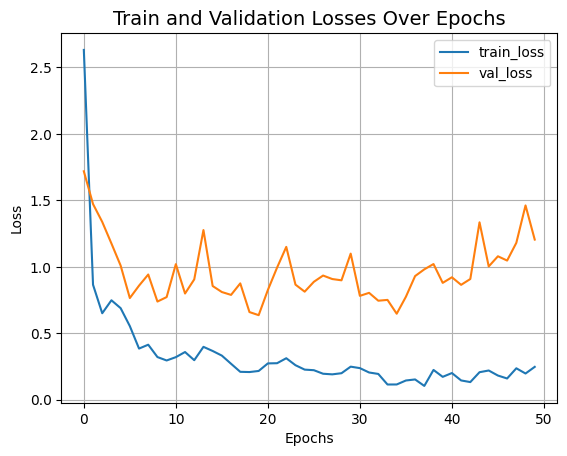

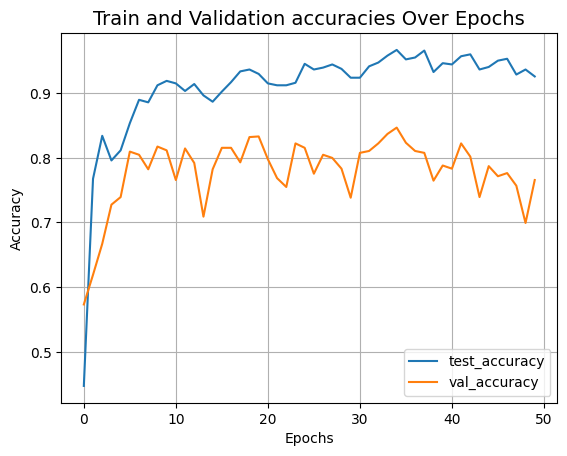

In [12]:
plt.plot(hist["loss"], label="train_loss")
plt.plot(hist["val_loss"], label="val_loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Train and Validation Losses Over Epochs", fontsize=14)
plt.legend()
plt.grid()
plt.show()

plt.plot(hist["accuracy"], label="test_accuracy")
plt.plot(hist["val_accuracy"], label="val_accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Train and Validation accuracies Over Epochs", fontsize=14)
plt.legend()
plt.grid()
plt.show()

In [13]:
model.evaluate(validation)

32/32 [==============================] - 18s 433ms/step - loss: 0.6454 - accuracy: 0.8461


[0.6453525424003601, 0.8460784554481506]

In [14]:
model.evaluate(test)

32/32 [==============================] - 15s 441ms/step - loss: 0.8074 - accuracy: 0.8206


[0.8074102401733398, 0.820588231086731]

In [15]:
image_batch = []
label_batch = []
image_batch, label_batch = next(iter(test))

t = list(test.as_numpy_iterator())

for i in range(len(test)-1):
    image_batch = np.append(image_batch, t[i+1][0], axis=0)
    label_batch = np.append(label_batch, t[i+1][1], axis=0)


image_batch = image_batch
label_batch = label_batch

predicted_batch = model.predict(image_batch)
predicted_batch = tf.squeeze(predicted_batch).numpy()

predicted_ids = np.argmax(predicted_batch, axis=-1)

32/32 [==============================] - 17s 422ms/step


In [16]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Converter as previsões em rótulos de classe
predicted_classes = predicted_ids

# Obter os rótulos verdadeiros do conjunto de dados de validação
true_classes = label_batch#np.argmax(y_test, axis=1)

# Calcular a precisão
accuracy = np.mean(predicted_classes == true_classes)
print('Precisão:', accuracy)

Precisão: 0.8205882352941176


In [17]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Obtendo as previsões do modelo para o conjunto de teste
y_pred = predicted_classes

# Obtendo os rótulos verdadeiros do conjunto de teste
y_true = true_classes

# Calculando o recall ponderado
weighted_recall = recall_score(y_true, y_pred, average='weighted')

# Calculando a precisão ponderada
weighted_precision = precision_score(y_true, y_pred, average='weighted')

# Calculando o F1-score ponderado
weighted_f1_score = f1_score(y_true, y_pred, average='weighted')

# Imprimindo os resultados
print("Weighted Recall:", weighted_recall)
print("Weighted Precision:", weighted_precision)
print("Weighted F1-Score:", weighted_f1_score)

Weighted Recall: 0.8205882352941176
Weighted Precision: 0.8601890075312495
Weighted F1-Score: 0.8174978356699486
